In [1]:
import sys
sys.dont_write_bytecode = True
import pandas as pd
import pickle
import bz2
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import numpy as np
import marshal
import time
import collections
import os

2023-12-12 09:33:57.606126: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-12 09:33:57.871320: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-12 09:33:57.871369: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-12 09:33:57.872079: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-12 09:33:57.962147: I tensorflow/core/platform/cpu_feature_g

In [2]:
from docker_agent_logger.app.src.AI import *

Using TensorFlow backend


In [3]:
raw_ds = ( #.filter(lambda x: tf.strings.length(x) > MIN_TRAINING_SEQ_LEN)
    tf.data.TextLineDataset("persistent_volume/data/BGL/BGL.log")
    # .batch(128)
    # .shuffle(buffer_size=256)
)

2023-12-06 14:31:24.812568: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22312 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:b3:00.0, compute capability: 8.6


In [57]:
for i in raw_ds.take(1000):
    print(i)

tf.Tensor(b'- 1117838570 2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.42.50.363779 R02-M1-N0-C:J12-U11 RAS KERNEL INFO instruction cache parity error corrected', shape=(), dtype=string)
tf.Tensor(b'- 1117838570 2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.42.50.527847 R02-M1-N0-C:J12-U11 RAS KERNEL INFO instruction cache parity error corrected', shape=(), dtype=string)
tf.Tensor(b'- 1117838570 2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.42.50.675872 R02-M1-N0-C:J12-U11 RAS KERNEL INFO instruction cache parity error corrected', shape=(), dtype=string)
tf.Tensor(b'- 1117838570 2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.42.50.823719 R02-M1-N0-C:J12-U11 RAS KERNEL INFO instruction cache parity error corrected', shape=(), dtype=string)
tf.Tensor(b'- 1117838570 2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.42.50.982731 R02-M1-N0-C:J12-U11 RAS KERNEL INFO instruction cache parity error corrected', shape=(), dtype=string)
tf.Tensor(b'- 1117838571 2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.

In [ ]:
def get_labels(data: tf.Tensor):
    data = data.decode("utf-8")
    if data[0] == "-":
        return (data[2:],False)
    else:
        return (data,True)
    
# ds = raw_ds.map(lambda x: tf.numpy_function(func=get_labels,inp=[x],Tout=(tf.string,tf.bool)), num_parallel_calls=tf.data.AUTOTUNE).prefetch(
#     tf.data.AUTOTUNE
# )
ds = raw_ds.map(lambda x: tf.numpy_function(func=get_labels,inp=[x],Tout=(tf.string,tf.bool)), num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)

In [ ]:
with open("docker_agent_logger/app/logs_tokenizer/vocab_labeled.pkl","rb") as f:
    vocab = pickle.load(f)

tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
            vocabulary=vocab,)

ds_tokenized = ds.map(lambda x,y: (tokenizer(x),y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

for i in ds_tokenized.take(2):
    print(i,len(i[0].numpy()[0]))

In [81]:
#get max len, mean len and std len 
seq_lens = []
for i in ds_tokenized:
    seq_lens.append(len(i[0].numpy()[0]))

seq_lens = np.array(seq_lens)
print(seq_lens.max())
print(seq_lens.mean())
print(seq_lens.std())
print(seq_lens.min())
print(len(seq_lens))

734
107.94517627875365
39.62624366849247
56
4747963


In [51]:
vocab_size = 5000
max_len=85
epochs=16
chkpt = "docker_agent_logger/app/trained_classifier/3"
MAN_TRAINING_SEQ_LEN = 1000

raw_ds = (
    tf.data.TextLineDataset("persistent_volume/data/BGL/BGL.log")
    # .filter(lambda x: tf.strings.length(x) < MAN_TRAINING_SEQ_LEN)
    # .batch(128)
    # .shuffle(buffer_size=256)
)

# vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
#             raw_ds,
#             vocabulary_size=vocab_size,
#             reserved_tokens=["[PAD]", "[UNK]", "[BOS]","[EOS]"],
#         )

# with open("docker_agent_logger/app/logs_tokenizer/vocab.pkl","wb") as f:
#     pickle.dump(vocab,f)

with open("docker_agent_logger/app/logs_tokenizer/vocab_bgl.pkl","rb") as f:
    vocab = pickle.load(f)

tokenizer = Tokenizer(vocab=vocab,max_len=max_len)

def get_labels(data: tf.Tensor):
    data = data.decode("utf-8")
    if data[0] == "-":
        return (data[2:],False)
    else:
        return (data,True)
    



ds = raw_ds.map(lambda x: tf.numpy_function(func=get_labels,inp=[x],Tout=(tf.string,tf.bool)), num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)

# ds_tokenized = ds.map(lambda x,y: (tf.numpy_function(func=tokenizer.vectorization,inp=[x],Tout=tf.int32),y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(
#     tf.data.AUTOTUNE
# )
ds_tokenized = ds.map(lambda x,y: (tokenizer.vectorization(x)[0],y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)



val_split = 0.2
ds_size = 4747963

train_size = int((1-val_split) * ds_size)
val_size = int(val_split * ds_size)

train_ds = ds_tokenized.take(train_size).shuffle(buffer_size=train_size).batch(128)
val_ds = ds.skip(train_size).take(val_size)



model = Model(vocab_size = vocab_size,latent_dim=max_len//2,embedding_dim=128,max_len = max_len)

model.vae.load_model(chkpt=chkpt) #17 for the other model

# model.train_model(ds,epochs=epochs,chkpt=chkpt)






Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 85)]                 0         []                            
 )                                                                                                
                                                                                                  
 input_embedding (TokenAndP  (None, 85, 128)              650880    ['input_word_ids[0][0]']      
 ositionEmbedding)                                                                                
                                                                                                  
 encoding (TransformerEncod  (None, 85, 128)              77482     ['input_embedding[0][0]']     
 er)                                                                                        

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for docker_agent_logger/app/trained_classifier/3encoder

In [4]:
from docker_agent_reader.app.src.AI_rnd import *

In [ ]:
for i in train_ds.take(1):
    print(i)

In [ ]:
for i in val_ds.take(1):
    print(i)

In [ ]:
for i in ds_tokenized.batch(10).take(1):
    print(i)

2023-12-06 13:37:00.638224: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:34: Filling up shuffle buffer (this may take a while): 1 of 60000
2023-12-06 13:37:05.405570: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


12.2595


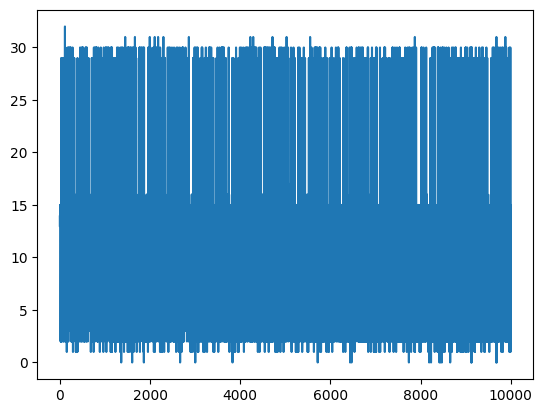

In [12]:
#counting mean padding
pad = []
for data,label in ds_tokenized.skip(train_size).shuffle(buffer_size=60000).batch(1).take(10000):
    pad.append(tf.reduce_sum(tf.cast(tf.equal(data,0),tf.int32)).numpy())

plt.plot(pad)
print(np.mean(pad))


In [24]:
with open("sample_logs.txt","w") as f:
    for logs in raw_ds.skip(train_size).take(5000).batch(1):
        f.write(logs.numpy()[0].decode("utf-8")+"\n")

In [16]:
#keep a dataset with an anomaly rate of 1%
with open("test_set_bgl.txt","a") as f:
    count = 0
    anomalies = 0
    for logs in val_ds.take(949592//2).batch(1):
        count += 1
        if logs[1].numpy()[0] == True:
            anomalies += 1
            f.write(logs[0].numpy()[0].decode("utf-8")+"\n")
        else:
            if anomalies/count > 0.01:
                f.write("- "+logs[0].numpy()[0].decode("utf-8")+"\n")


In [19]:
raw_ds = (
    tf.data.TextLineDataset("persistent_volume/data/BGL/test_set_bgl.txt")
    # .filter(lambda x: tf.strings.length(x) < MAN_TRAINING_SEQ_LEN)
    # .batch(128)
    # .shuffle(buffer_size=256)
)
ds = raw_ds.map(lambda x: tf.numpy_function(func=get_labels,inp=[x],Tout=(tf.string,tf.bool)), num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)

for i in ds.take(3).batch(1):
    print(i)

(<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'KERNNOETH 1131113126 2005.11.04 R70-M0-N4-I:J18-U11 2005-11-04-06.05.26.826558 R70-M0-N4-I:J18-U11 RAS KERNEL FATAL no ethernet link'],
      dtype=object)>, <tf.Tensor: shape=(1,), dtype=bool, numpy=array([ True])>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'KERNMC 1131143766 2005.11.04 R35-M1-NA-C:J08-U01 2005-11-04-14.36.06.220414 R35-M1-NA-C:J08-U01 RAS KERNEL FATAL machine check interrupt'],
      dtype=object)>, <tf.Tensor: shape=(1,), dtype=bool, numpy=array([ True])>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'KERNRTSP 1131143822 2005.11.04 R35-M1-NA-C:J08-U01 2005-11-04-14.37.02.170925 R35-M1-NA-C:J08-U01 RAS KERNEL FATAL rts panic! - stopping execution'],
      dtype=object)>, <tf.Tensor: shape=(1,), dtype=bool, numpy=array([ True])>)


In [ ]:
print(data)

In [51]:
print(val_size)

949592


In [52]:
percentile = 99
anomaly_detector = AnomalyDetector(latent_space_dim=max_len//2,threshold=np.inf)
data = {"logs":[],"parsed_logs":[],"vectorized_logs":[],"encoded_logs":[]}
times = {"parsed_logs":[],"vectorized_logs":[],"encoded_logs":[],"anomaly":[],"anomaly_rnd":[]}
recostruction_loss = []
recostruction_loss_rnd = []
d = collections.deque(maxlen=1000)
d_rnd = collections.deque(maxlen=1000)
thresholds = [np.inf,]
thresholds_rnd = [np.inf,]


FP_rec = []
TP_rec = []
FN_rec = []
TN_rec = []

FP_rnd = []
TP_rnd = []
FN_rnd = []
TN_rnd = []


raw_ds = (
    tf.data.TextLineDataset("persistent_volume/data/BGL/test_set_bgl.txt")
    # .filter(lambda x: tf.strings.length(x) < MAN_TRAINING_SEQ_LEN)
    # .batch(128)
    # .shuffle(buffer_size=256)
)
ds = raw_ds.map(lambda x: tf.numpy_function(func=get_labels,inp=[x],Tout=(tf.string,tf.bool)), num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)



for logs in ds.batch(1):
    # t = time.time()
    # parsed_logs = tokenizer.parsing(logs)   
    t_parse = time.time()
    # times["parsed_logs"].append(t_parse-t)
    vectorized_logs = tokenizer.vectorization(logs[0])
    t_vectorize = time.time()
    times["vectorized_logs"].append(t_vectorize-t_parse)
    encoded_logs = model.vae.encode(vectorized_logs)
    t_encode = time.time()
    times["encoded_logs"].append(t_encode-t_vectorize)
    losses = model.vae.train_step(vectorized_logs,train=False)

    anomaly = logs[1].numpy()[0]
    if losses["reconstruction_loss"].numpy() > thresholds[-1]:
        if anomaly:
            TP_rec.append(logs[0].numpy()[0].decode("utf-8"))
        else:
            FP_rec.append(logs[0].numpy()[0].decode("utf-8"))
    else:
        if anomaly:
            FN_rec.append(logs[0].numpy()[0].decode("utf-8"))
        else:
            TN_rec.append(logs[0].numpy()[0].decode("utf-8"))

    d.append(losses["reconstruction_loss"].numpy())
    thresholds.append(np.percentile(d,percentile))
    
    t_anomaly = time.time()
    times["anomaly"].append(t_anomaly-t_encode)

    recostruction_loss_rnd_value, anomaly_rnd = anomaly_detector.detect(encoded_logs,thresholds_rnd[-1])

    if anomaly_rnd:
        if anomaly:
            TP_rnd.append(logs[0].numpy()[0].decode("utf-8"))
        else:
            FP_rnd.append(logs[0].numpy()[0].decode("utf-8"))
    else:
        if anomaly:
            FN_rnd.append(logs[0].numpy()[0].decode("utf-8"))
        else:
            TN_rnd.append(logs[0].numpy()[0].decode("utf-8"))

    d_rnd.append(recostruction_loss_rnd_value.numpy())
    thresholds_rnd.append(np.percentile(d_rnd,percentile))
    

    times["anomaly_rnd"].append(time.time()-t_anomaly)

    anomaly_detector.train_step(encoded_logs)


    recostruction_loss_rnd.append(recostruction_loss_rnd_value.numpy())
    recostruction_loss.append(losses["reconstruction_loss"].numpy())
    compressed_data = bz2.compress(pickle.dumps(logs))
    data["logs"].append(sys.getsizeof(compressed_data))
    # compressed_data = bz2.compress(pickle.dumps(parsed_logs))
    # data["parsed_logs"].append(sys.getsizeof(compressed_data))
    compressed_data = bz2.compress(pickle.dumps(vectorized_logs))
    data["vectorized_logs"].append(sys.getsizeof(compressed_data))
    compressed_data = bz2.compress(pickle.dumps(encoded_logs))
    data["encoded_logs"].append(sys.getsizeof(compressed_data))

Model: "fixed_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 42)]              0         
                                                                 
 dense_4 (Dense)             (None, 128)               5504      
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
Total params: 22016 (86.00 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 22016 (86.00 KB)
_________________________________________________________________
Model: "trainable_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 42)]              0         
                                                            

In [ ]:
data

In [ ]:
times

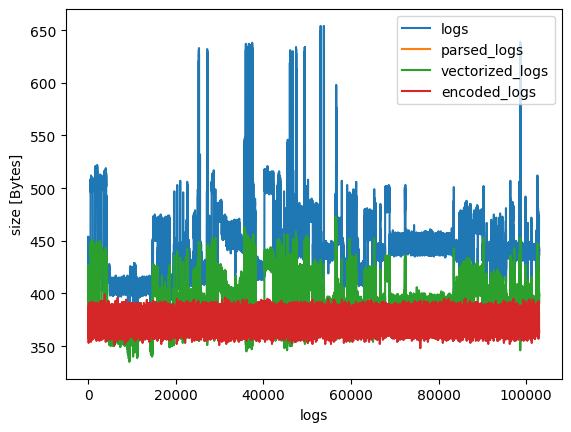

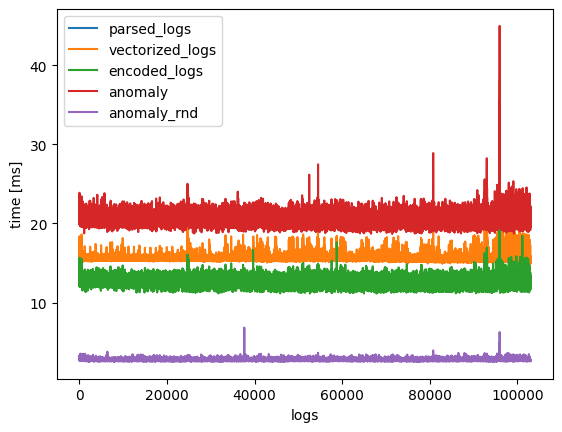

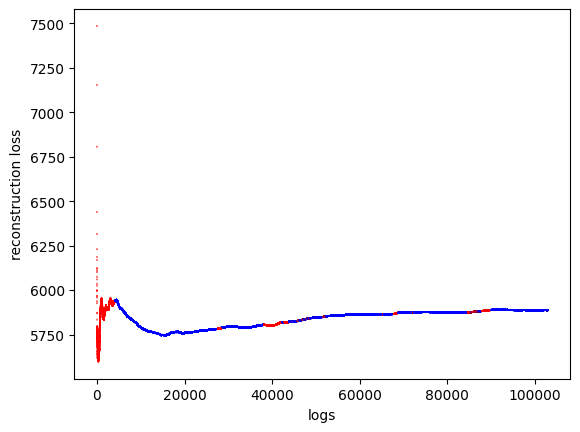

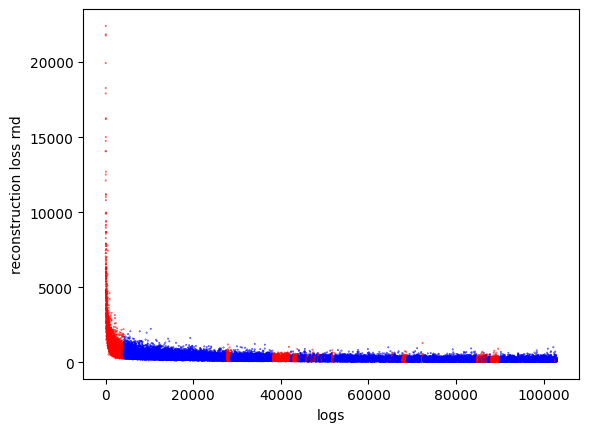

In [53]:
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots()
for key in data.keys():
    ax.plot(data[key], label=key)
    plt.xlabel('logs')
    plt.ylabel('size [Bytes]')
    plt.legend()

fig.savefig("data/size.png")

fig, ax = plt.subplots()
for key in times.keys():
    ax.plot(np.array(times[key][10:])*10**3, label=key)
    plt.xlabel('logs')
    plt.ylabel('time [ms]')
    plt.legend()

fig.savefig("data/time.png")

fig, ax = plt.subplots()
# ax.plot(thresholds)
cmap = ListedColormap(["blue","red"])
ax.scatter([i for i in range(len(recostruction_loss))],recostruction_loss, c = np.array(list((ds.batch(1).map(lambda x,y: int(y[0])).take(len(recostruction_loss)).as_numpy_iterator()))),cmap = cmap,s=0.1)
# ax.scatter(recostruction_loss)
plt.xlabel('logs')
plt.ylabel('reconstruction loss')


fig.savefig("data/reconstruction_loss.png")

fig, ax = plt.subplots()
# ax.plot(thresholds_rnd)
ax.scatter([i for i in range(len(recostruction_loss_rnd))],recostruction_loss_rnd, c = np.array(list((ds.batch(1).map(lambda x,y: int(y[0])).take(len(recostruction_loss_rnd)).as_numpy_iterator()))),cmap = cmap,s=0.1)
# ax.plot(recostruction_loss_rnd)
plt.xlabel('logs')
plt.ylabel('reconstruction loss rnd')

plt.savefig("data/reconstruction_loss_rnd.png")



plt.show()

In [ ]:
true_anomalies


In [26]:
false_labeled_anomalies 


['1131680550 2005.11.10 R55-M1-N7-C:J14-U11 2005-11-10-19.42.30.174740 R55-M1-N7-C:J14-U11 RAS KERNEL INFO 1 ddr errors(s) detected and corrected on rank 0, symbol 20, bit 5',
 '1131680550 2005.11.10 R55-M1-N7-C:J14-U11 2005-11-10-19.42.30.288374 R55-M1-N7-C:J14-U11 RAS KERNEL INFO CE sym 20, at 0x0a1b4e80, mask 0x04',
 '1131680550 2005.11.10 R55-M1-N7-C:J14-U11 2005-11-10-19.42.30.401999 R55-M1-N7-C:J14-U11 RAS KERNEL INFO total of 1 ddr error(s) detected and corrected',
 '1131680622 2005.11.10 - 2005-11-10-19.43.42.770441 RAS KERNEL FATAL Kill job 48912 timed out. Block freed.',
 '1131680963 2005.11.10 - 2005-11-10-19.49.23.136567 RAS KERNEL FATAL Kill job 48914 timed out. Block freed.',
 '1131681737 2005.11.10 R51-M1-N2-C:J12-U01 2005-11-10-20.02.17.970966 R51-M1-N2-C:J12-U01 RAS KERNEL INFO ddr: activating redundant bit steering for next allocation: rank=0 symbol=5',
 '1131682406 2005.11.10 R51-M1-N2-C:J12-U01 2005-11-10-20.13.26.673366 R51-M1-N2-C:J12-U01 RAS KERNEL INFO ddr: Unab

In [ ]:
true_labeled_anomalies 


[]

In [ ]:
false_labeled_anomalies_rnd 


In [ ]:
true_labeled_anomalies_rnd 

[]

In [56]:
with open("data/anomalies.txt","w") as f:
    f.write("true anomalies: {}\n".format(len(true_anomalies)))
    f.write("false labeled_anomalies: {}\n".format(len(false_labeled_anomalies)))
    f.write("true labeled anomalies: {}\n".format(len(true_labeled_anomalies)))
    f.write("precision: {}\n".format(len(true_labeled_anomalies)/(len(true_labeled_anomalies)+len(false_labeled_anomalies))))
    f.write("false labeled anomalies rnd: {}\n".format(len(false_labeled_anomalies_rnd)))
    f.write("true labeled anomalies rnd: {}\n".format(len(true_labeled_anomalies_rnd)))
    f.write("precision rnd: {}\n".format(len(true_labeled_anomalies_rnd)/(len(true_labeled_anomalies_rnd)+len(false_labeled_anomalies_rnd))))

    f.write("true anomalies:\n")
    for i in true_anomalies:
        f.write(i+"\n")
    f.write("false labeled anomalies:\n")
    for i in false_labeled_anomalies:
        f.write(i+"\n")
    f.write("true labeled anomalies:\n")
    for i in true_labeled_anomalies:
        f.write(i+"\n")
    f.write("false labeled anomalies rnd:\n")
    for i in false_labeled_anomalies_rnd:
        f.write(i+"\n")
    f.write("true labeled anomalies rnd:\n")
    for i in true_labeled_anomalies_rnd:
        f.write(i+"\n")


In [ ]:
# z = tf.random.normal(shape=(1,60 ,30),dtype=tf.float32)
encode_token = val_ds.take(1).batch(1).as_numpy_iterator().next()

print(encode_token)


z = model.vae.encoder(tokenizer.preprocess(encode_token))[0]

tokens = model.vae.decode(z)

print((tokenizer.decode(tokens).numpy()))


In [ ]:
def plot_label_clusters(vae, name,data):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1])
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    # plt.savefig("./results/"+name+".png")
    plt.show()

# model = Model(vocab_size = vocab_size,latent_dim=256,embedding_dim=128,max_len = max_len)


# for i in range(32):
#     model.vae.load_model(chkpt=chkpt+str(i))

#     plot_label_clusters(model.vae, "cluster"+str(i),ds)

ds_val_pre = val_ds.map(tokenizer.preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)

plot_label_clusters(model.vae, "cluster"+str(17),ds_val_pre.take(10000).batch(128))